In [ ]:
import os
from pathlib import Path
from gurobipy import Model, GRB
from data_loader import load_prices, load_storage, load_efficiency, load_plant_capacity, load_demand
import pandas as pd

# Data Loading from data folder in the parent directory
current_dir = Path().resolve()
data_folder = os.path.join(current_dir.parent, "data")
fuel_prices_file = os.path.join(data_folder, "fuel_prices.csv")             # Price in EUR/tonne (coal,oil) or EUR/m3 (gas)
storage_file = os.path.join(data_folder, "storage.csv")                     # Max storage in tonnes/m3
efficiency_file = os.path.join(data_folder, "efficiency.csv")               # efficiency of MWh th to MWh el
plant_file = os.path.join(data_folder, "plant_capacity.csv")                # Plant capacity in MWh/month
demand_file = os.path.join(data_folder, "electricity_demand.csv")           # Monthly demand in MWh

start_date = "2020-01"
end_date = "2020-12"
fuels = ["coal", "oil", "gas"]
zone = 'DK_1'  # Specify the zone for demand data
resample_method = 'M' # Monthly resampling 

try:
    fuel_prices_df = load_prices(fuel_prices_file, start_date, end_date, resample_method= resample_method)
    storage = load_storage(storage_file)
    efficiency = load_efficiency(efficiency_file)
    plant_capacity = load_plant_capacity(plant_file)
    demand_df = load_demand(demand_file, start_date, end_date, resample_method= resample_method ,zone=zone ,supply_factor=0.0005)
except Exception as e:
    raise RuntimeError(f"Error loading data: {e}")

# periods as Month PeriodIndex (so days_in_month works)
periods = demand_df.index.to_period('M')

print( periods)


# Forloop over each timestep and saving results in df results
results = pd.DataFrame(columns=['Month', 'Cost_EUR','Accumulated_Cost' , 'Coal_Bought', 'Oil_Bought', 'Gas_Bought',
                                   'Coal_Generated', 'Oil_Generated', 'Gas_Generated'])

for t in range(len(demand_df)):
    print(f"Time step: {t}, Date: {demand_df.index[t]}")
    
    # Model Initialization
    m = Model("Fuel_Procurement_OneMonth")

    # Decision Variables
    x = {fuel: m.addVar(lb=0, ub=storage[fuel], name=f"buy_{fuel}") for fuel in fuel_prices_df.columns if fuel in fuels}
    #y = {fuel: m.addVar(lb=0, ub=plant_capacity[fuel], name=f"gen_{fuel}") for fuel in fuel_prices_df.columns if fuel in fuels}    
    
    y = {}
    for fuel in fuels:
                            
            hours_in_month = periods[t].days_in_month * 24

            print(f"Hours in month {periods[t]}: {hours_in_month}")
            # plant_capacity[fuel] is MW -> convert to MWh/month
            monthly_capacity_mwh = plant_capacity.get(fuel, 0) * hours_in_month
            y[fuel] = m.addVar(lb=0, ub=monthly_capacity_mwh, name=f"use_{fuel}_{t}")

    m.update()

    # Constraints
    m.addConstr(sum(y[fuel] for fuel in y) >= demand_df.iloc[t][zone], "Demand_Constraint")
    for fuel in y:
        m.addConstr(y[fuel] <= efficiency[fuel] * x[fuel], f"efficiency_Constraint_{fuel}")
        # Print the added constraint for verification
        print(f"Added constraint: gen_{fuel} <= {efficiency[fuel]} * buy_{fuel}")
    m.update()

    # Objective
    m.setObjective(sum(fuel_prices_df.iloc[t][fuel] * x[fuel] for fuel in x),GRB.MINIMIZE) 
    m.update()

    # Optimize
    m.optimize()

    # print results
    if m.status == GRB.OPTIMAL:
        total_cost = m.objVal
        print(f"Total Cost: EUR {total_cost}")
    else:
        print("No optimal solution found for time step:", t)
        # Exit the loop if no optimal solution is found
        break
    # Store results
    results = pd.concat([results, pd.DataFrame([{
        'Month': demand_df.index[t],
        'Cost_EUR': total_cost,
        'Accumulated_Cost': results['Cost_EUR'].sum() + total_cost,
        'Coal_Bought': x['coal'].X if 'coal' in x else 0,
        'Oil_Bought': x['oil'].X if 'oil' in x else 0,
        'Gas_Bought': x['gas'].X if 'gas' in x else 0,
        'Coal_Generated': y['coal'].X if 'coal' in y else 0,
        'Oil_Generated': y['oil'].X if 'oil' in y else 0,
        'Gas_Generated': y['gas'].X if 'gas' in y else 0
    }])], ignore_index=True)



# Print running cost for each month
print(results)

# Summarize Yearly Cost
total_yearly_cost = results['Accumulated_Cost'].iloc[-1]
print(f"Total Cost for Period: EUR {total_yearly_cost}")

/Users/rofrug/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/First Year PhD/46750 Optimization in modern power systems/46750_g28_Assignment_2/src/data_loader.py:81: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample(resample_method).mean()


PeriodIndex(['2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06',
             '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12'],
            dtype='period[M]', name='utc_timestamp')
Time step: 0, Date: 2020-01-31 00:00:00
Added constraint: gen_coal <= 0.38 * buy_coal
Added constraint: gen_oil <= 0.33 * buy_oil
Added constraint: gen_gas <= 0.55 * buy_gas
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 25.1.0 25B78)

CPU model: Apple M4
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 4 rows, 6 columns and 9 nonzeros
Model fingerprint: 0xb89f6665
Coefficient statistics:
  Matrix range     [3e-01, 1e+00]
  Objective range  [6e+00, 5e+01]
  Bounds range     [4e+03, 3e+09]
  RHS range        [1e+03, 1e+03]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 3 rows and 3 columns
Presolve time: 0.00s
Presolved: 1 rows

/Users/rofrug/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/First Year PhD/46750 Optimization in modern power systems/46750_g28_Assignment_2/src/data_loader.py:193: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df[selected_col].resample(resample_method).sum()
/var/folders/8b/6z2b3l6952gg8zq23ybm69hr0000z9/T/ipykernel_20767/56108678.py:87: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([{


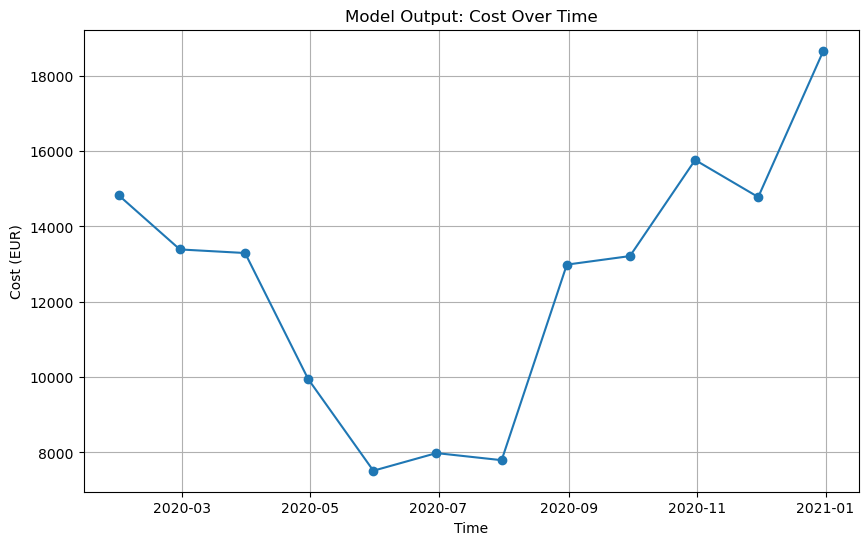

In [11]:
# plot results
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(demand_df.index, results['Cost_EUR'], marker='o')
plt.title('Model Output: Cost Over Time')
plt.xlabel('Time')
plt.ylabel('Cost (EUR)')
plt.grid()
plt.show()


In [12]:
# save results to a csv file

results_dir = os.path.join(current_dir.parent, "results/model1")
os.makedirs(results_dir, exist_ok=True)
results.to_csv(os.path.join(results_dir, 'model1_results.csv'), index=False)

